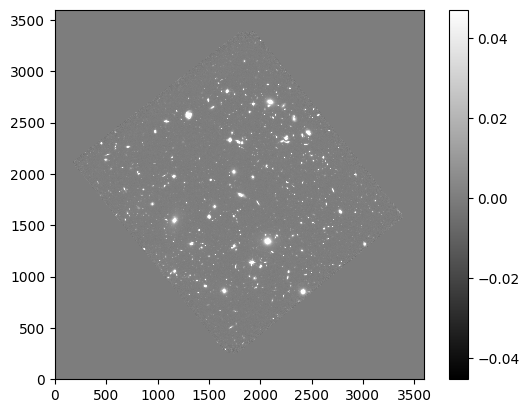

In [1]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from astropy.io import fits

# read image
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits') as hdul:
    data = hdul[0].data

# display image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig('original_image.png')  # saving image
plt.show()


0.0
0.0004939954960718751


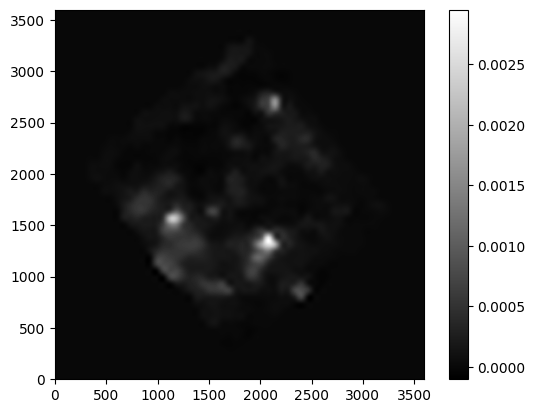

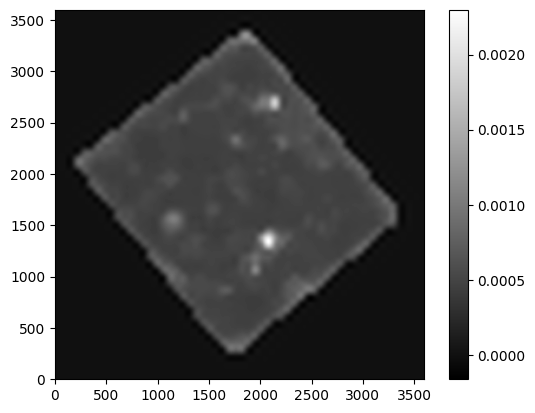

In [2]:
# data is in the native byte order
data = data.byteswap().newbyteorder()

# measure and remove background
bkg = sep.Background(data)
print(bkg.globalback)
print(bkg.globalrms)

# evaluate background
bkg_image = bkg.back()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig('background.png')
plt.show()

# evaluate background noise
bkg_rms = bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig('background_noise.png')
plt.show()

# remove background
data_sub = data - bkg


Number of objects detected: 7643


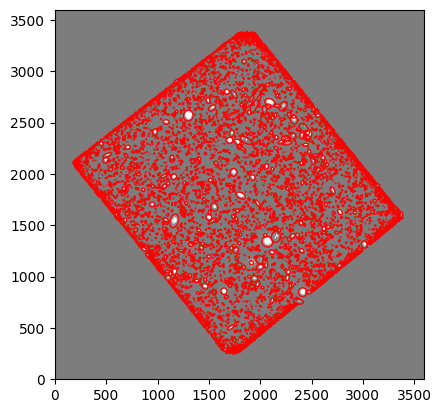

In [3]:
# object detection mode activated!
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
print(f"Number of objects detected: {len(objects)}")

# display detected objects
from matplotlib.patches import Ellipse

fig, ax = plt.subplots()
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('detected_objects.png')
plt.show()


In [4]:
# aperture photometry
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

# print results (I did first 10 if you want more you can alter it)
for i in range(10):
    print(f"object {i}: flux = {flux[i]} +/- {fluxerr[i]}")


object 0: flux = 0.016473572156019144 +/- 0.12837641002986055
object 1: flux = 0.018756227968706296 +/- 0.13697857197772045
object 2: flux = -0.0020255340353105638 +/- 0.002623297509799915
object 3: flux = 0.021291554175759307 +/- 0.14593983645867303
object 4: flux = 0.0189560277459168 +/- 0.13770588017852298
object 5: flux = 0.008720834887681118 +/- 0.09342240556361482
object 6: flux = 0.01463417406957887 +/- 0.1210002304105401
object 7: flux = 0.04603338435076695 +/- 0.2145699333069051
object 8: flux = 0.01584966419031842 +/- 0.12592277744770142
object 9: flux = -0.01922873561154121 +/- 0.0026232975097999147


Mean Flux: 0.3896667700720729
Median Flux: 0.02858241294423352
Standard Deviation of Flux: 8.151146675772823
Largest Outlier Flux: 653.6385420036319
Number of Standard Deviations from Mean: 80.14196053853053
Location of Outlier (x, y): (1914.3845107201428, 1134.2795239679708)


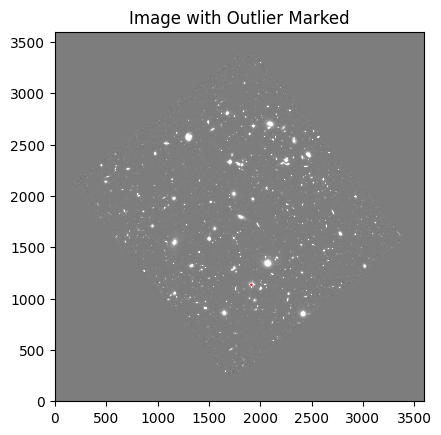

In [5]:
# what are the mean, median, and standard deviation of the distribution of fluxes. 
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)

print(f"Mean Flux: {mean_flux}")
print(f"Median Flux: {median_flux}")
print(f"Standard Deviation of Flux: {std_flux}")

# outlier
max_flux = np.max(flux)
outlier_index = np.argmax(flux)  # index of outlier
outlier_value = flux[outlier_index]
outlier_distance = (outlier_value - mean_flux) / std_flux

print(f"Largest Outlier Flux: {outlier_value}")
print(f"Number of Standard Deviations from Mean: {outlier_distance}")

# location of the outlier on the image
outlier_x, outlier_y = objects['x'][outlier_index], objects['y'][outlier_index]
print(f"Location of Outlier (x, y): ({outlier_x}, {outlier_y})")

# display marked outlier
fig, ax = plt.subplots()
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
e = Ellipse(xy=(outlier_x, outlier_y), width=10, height=10, angle=0)
e.set_facecolor('none')
e.set_edgecolor('red')
ax.add_artist(e)
plt.title("Image with Outlier Marked")
plt.savefig('image_with_outlier.png')
plt.show()
